In [104]:
# Read the labeled data from the provided CSV file.
csv = pd.read_csv('HW03_Abominable_Training____Data_v2205_n222.csv')

In [105]:
# Replace all occurances of 'Assam' in the labels to -1, and 'Bhuttan' to 1.
replace = lambda datapoint : datapoint if (datapoint not in {'Assam','Bhuttan'}) else {'Assam':-1, 'Bhuttan':1}[datapoint]
csv['Class'] = csv['Class'].apply(replace) # Apply the lambda function to data
csv = csv.to_numpy()

In [106]:
# Separate out the labels from the attribute data.
labels = csv[:,-1]

### Data Quantization:

In [107]:
# Round the age data to the nearest multiple of 2.
quantize = np.vectorize( lambda datapoint : 2 * round(datapoint/2) )

In [108]:
# Retrieve all the data, and quantize: round to the nearest two.
age_data = quantize( csv[:,0] )
height_data = quantize( csv[:,1] )
tail_len_data = quantize( csv[:,2] )
hair_len_data = quantize( csv[:,3] )
bang_ln_data = quantize( csv[:,4] )
reach_data = quantize( csv[:,5] )

In [109]:
attributes = dict()
attributes['Age'] = age_data
attributes['Height'] = height_data
attributes['Tail Length'] = tail_len_data
attributes['Hair Length'] = hair_len_data
attributes['Bang Length'] = bang_ln_data
attributes['Reach'] = reach_data

### Threshold-finding:

In [110]:
def count_misclassifications( x_train, y_train, threshold, left_classification ):
    '''
    Count the number of misclassifications that occur if the data is classified according
    to the provided threshold, where the data to the left of the threshold is classified 
    as the left_classification parameter. 
    '''
    # Left subset misclassifications, Right subset misclassifications.
    MLS, MRS = 0, 0 
    for index, data_point in enumerate(x_train):
        if( data_point <= threshold ): # Data-point falls in the LHS. 
            if( y_train[index] != left_classification ): #< check if data-point is misclassified.
                MLS = MLS + 1
        else: # Data-point falls in the RHS. 
            if( y_train[index] != left_classification*(-1) ): #< check if data-point is misclassified.
                MRS = MRS + 1
    
    # Return the number of misclassification in the Left subset and the Right subset.
    return MLS, MRS 

def optimal_threshold( x_train, y_train, quantized_unit=2 ):
    '''
    Test all the possible threshold values for a given attribute to classify a dataset with, and returns the 
    threshold value which yields the least number of misclassifications in the resultant subsets. 
    '''
    best_missclassification = np.Infinity # Sentinel value, so that we can only go lower.  
    best_threshold = np.NaN  # sentinel value. Only returned if something went wrong. 
    best_left_classification = np.NaN # sentinel value. Only returned if something went wrong. 
    
    # Iterate through all possible left classes:
    for left_classification in [1, -1]:
        # Iterate through all possible threshold values:
        for threshold in range( min(x_train), max(x_train) + quantized_unit, quantized_unit ):
            
            # Find the number of misclassifications in the left and right sides:
            MLS, MRS = count_misclassifications( x_train, y_train, threshold, left_classification )
            # Form the total measure of mistakes:
            measure_of_mistakes = MLS + MRS
            
            # Break ties by using the first value found.
            # REASONING:
            # This is because it will make comparing each one rule against each other easier,
            # since each threshold corresponding to an attribute will hold the same number of 
            # misclassification. It wouldn't help in comparison, and the extra comparisons 
            # can be wasteful. 
            if( measure_of_mistakes < best_missclassification ):
                best_missclassification = measure_of_mistakes
                best_threshold = threshold
                best_left_classification = left_classification
    
    # Return the best threshold to split the data at, and which class the left subset will be assigned. 
    return best_threshold, best_left_classification


* #### Utility function: Print one-rule:

In [111]:
def print_rule( classifier, attribute_name ):
    '''
    Print the one-rule defined by a attribute-specific-classifier as an if-else statement.
    '''
    optimal_threshold, optimal_left_class = classifier
    print(f"if ( {attribute_name} <= {optimal_threshold} ): \n\tclass = {'Assam' if optimal_left_class==-1 else 'Bhutan' }",
      f"\nelse: \n\tclass = {'Bhutan' if optimal_left_class==-1 else 'Assam' }" )

### Find the best one-rule:

In [173]:
def calculate_statistics(x_train, y_train, threshold, left_classification, target, quantized_unit = 2):
    '''
    Takes in attribute data and calculates the false positive rate and true alarm rates for our ROC curves 

    returns: ( FP_Rate, TP_Rate ) [tuple]
    '''
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        
        for index, data_point in enumerate(x_train):
            if( left_classification != target ): # LEFT is not Target
                if( data_point <= threshold ): # Predicted: LEFT (!TARGET).
                    if( y_train[index] == left_classification ): # Found: LEFT (!TARGET). 
                        TN = TN + 1
                    else:
                        # Found: !LEFT (TARGET)
                        FN = FN + 1
                else:
                # Predicted: RIGHT (TARGET)
                    if( y_train[index] == (-1)*left_classification ): # Found: RIGHT (TARGET).
                        TP = TP + 1
                    else:
                        # Found: (!TARGET)
                        FP = FP + 1
            else:
                if( data_point <= threshold ): # Predicted: LEFT (TARGET).
                    if( y_train[index] == left_classification ): # Found: (TARGET).
                        TP = TP + 1
                    else:
                        FP = FP + 1
                else:
                # Predicted: RIGHT
                    if( y_train[index] == (-1)*left_classification ): # Found: RIGHT.
                        TN = TN + 1
                    else:
                        FN = FN + 1
                        
        FP_rate = FP / (FP + TN) 
        TP_rate = TP / (TP + FN) 
        
        return FP_rate, TP_rate

def get_roc_data( target, attribute_name, x_train, y_train, quantized_unit = 2 ):
    '''
    We iterate through all the possible threshold values and then calculate the ROC curve data for a given attribute.

    :returns ( list of true positive rates, list of false alarm rates, 
                the TP corresponding to least misclassification,
                the FP corresponding to least misclassification,
                do we want annotation to be drawn on screen? )
    '''
    best_threshold, left_classification = optimal_threshold( x_train, y_train )
    lowest_misclassified = sum(count_misclassifications( x_train, y_train, best_threshold, left_classification ))
    
    FP_rates = []
    TP_rates = []
    
    # Sentinel values
    best_FP = np.NaN
    best_TP = np.NaN
    
    # Iterate through all possible threshold values:
    for threshold in range( min(x_train), max(x_train) + quantized_unit, quantized_unit ):
        FP_rate, TP_rate = calculate_statistics(x_train, y_train, threshold, left_classification, target)
        FP_rates.append(FP_rate)
        TP_rates.append(TP_rate)
        
        if( threshold == best_threshold ):
            best_FP = FP_rate
            best_TP = TP_rate
    
    annotation = f'Best {attribute_name} Threshold <= {best_threshold} : {left_classification} \nLowest # Misclassified = {lowest_misclassified}'
    
    return FP_rates, TP_rates, best_FP, best_TP, annotation

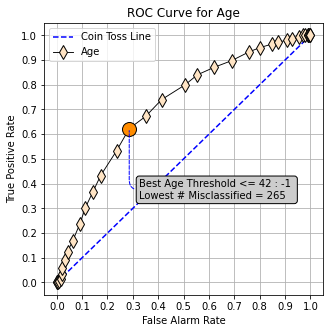

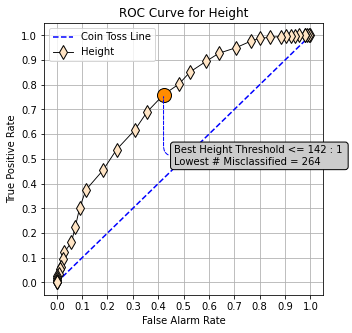

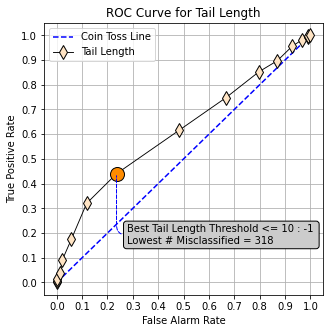

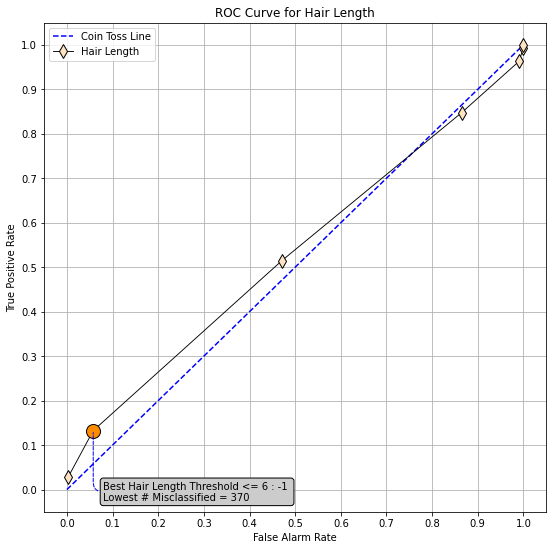

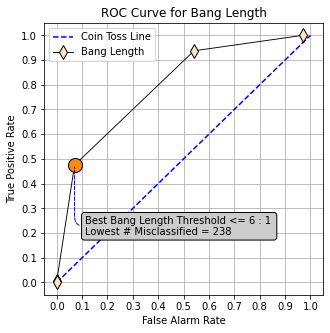

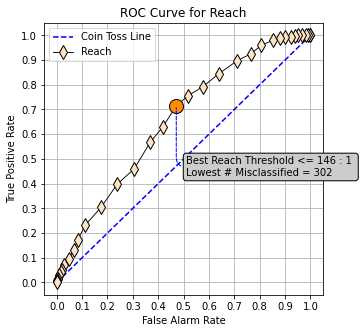

In [197]:
target = -1

for attribute_name in attributes.keys():
    if( attribute_name == 'Hair Length' ):
        figure, ax = plt.subplots(figsize=(9,9))
    else:
        figure, ax = plt.subplots(figsize=(5,5))
    plt.title(f'ROC Curve for {attribute_name}') 

    plt.xlabel('False Alarm Rate')
    plt.ylabel('True Positive Rate')
    plt.xticks( [ tick*0.1 for tick in range(0,11) ] )
    plt.yticks( [ tick*0.1 for tick in range(0,11) ] )

    plt.grid()

    attribute_data = attributes[attribute_name]
    results = get_roc_data(target, attribute_name, attribute_data, labels)
    plt.plot( [0,1], [0,1], color='blue', linestyle='--', label='Coin Toss Line' )
    plt.plot( results[0], results[1], color='k', marker = 'd', markerfacecolor='bisque', markersize=10, linewidth=0.9, label = attribute_name ) 
    plt.plot( results[2], results[3], color='k', marker = 'o', markerfacecolor='darkorange', markersize=14 )

    ax.annotate(
        results[4],
        xy=results[2:4], xycoords='data',
        xytext=(10, -70), textcoords='offset points',
        bbox=dict(boxstyle="round", fc="0.8"),
        arrowprops=dict(arrowstyle="-", linestyle='--', color='blue',
        connectionstyle="angle,angleA=0,angleB=90,rad=10"))     

    plt.legend()
    plt.show()

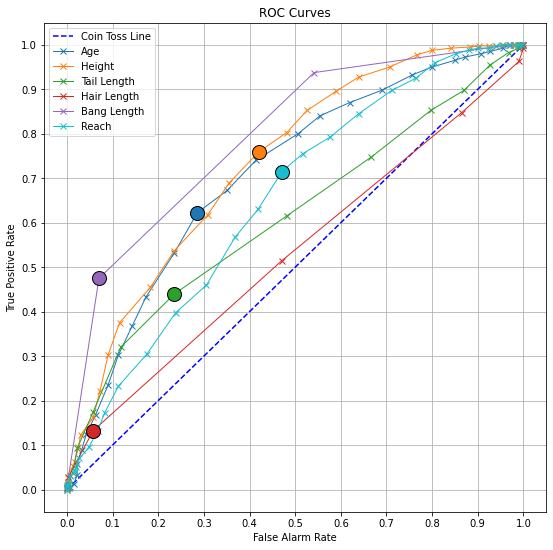

In [192]:
figure, ax = plt.subplots(figsize=(9,9))
plt.title(f'ROC Curves') 

plt.xlabel('False Alarm Rate')
plt.ylabel('True Positive Rate')
plt.xticks( [ tick*0.1 for tick in range(0,11) ] )
plt.yticks( [ tick*0.1 for tick in range(0,11) ] )

plt.grid()
plt.plot( [0,1], [0,1], color='blue', linestyle='--', label='Coin Toss Line' )

colors = ['tab:blue','tab:orange', 'tab:green', 'tab:red', 'tab:purple','tab:cyan']

for index, attribute_name in enumerate(attributes.keys()):
    attribute_data = attributes[attribute_name]
    results = get_roc_data(target, attribute_name, attribute_data, labels)
    plt.plot( results[0], results[1], color = colors[index], marker = 'x', linewidth=1, label = attribute_name ) 

for index, attribute_name in enumerate(attributes.keys()):
    attribute_data = attributes[attribute_name]
    results = get_roc_data(target, attribute_name, attribute_data, labels)
    plt.plot( results[2], results[3], color='k', marker = 'o', markerfacecolor = colors[index], markersize=14 )

# plt.axvline( best_threshold, color='r', label = 'Best Threshold', linestyle='--' )

plt.legend()
plt.show()

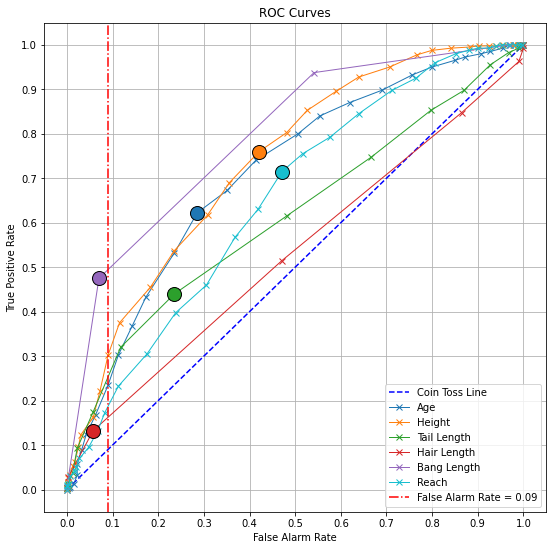

In [193]:
figure, ax = plt.subplots(figsize=(9,9))
plt.title(f'ROC Curves') 

plt.xlabel('False Alarm Rate')
plt.ylabel('True Positive Rate')
plt.xticks( [ tick*0.1 for tick in range(0,11) ] )
plt.yticks( [ tick*0.1 for tick in range(0,11) ] )

plt.grid()
plt.plot( [0,1], [0,1], color='blue', linestyle='--', label='Coin Toss Line' )

colors = ['tab:blue','tab:orange', 'tab:green', 'tab:red', 'tab:purple','tab:cyan']

for index, attribute_name in enumerate(attributes.keys()):
    attribute_data = attributes[attribute_name]
    results = get_roc_data(target, attribute_name, attribute_data, labels)
    plt.plot( results[0], results[1], color = colors[index], marker = 'x', linewidth=1, label = attribute_name ) 

for index, attribute_name in enumerate(attributes.keys()):
    attribute_data = attributes[attribute_name]
    results = get_roc_data(target, attribute_name, attribute_data, labels)
    plt.plot( results[2], results[3], color='k', marker = 'o', markerfacecolor = colors[index], markersize=14 )

plt.axvline( 0.09, color = 'red', label = 'False Alarm Rate = 0.09', linestyle = '-.' )

plt.legend()
plt.show()

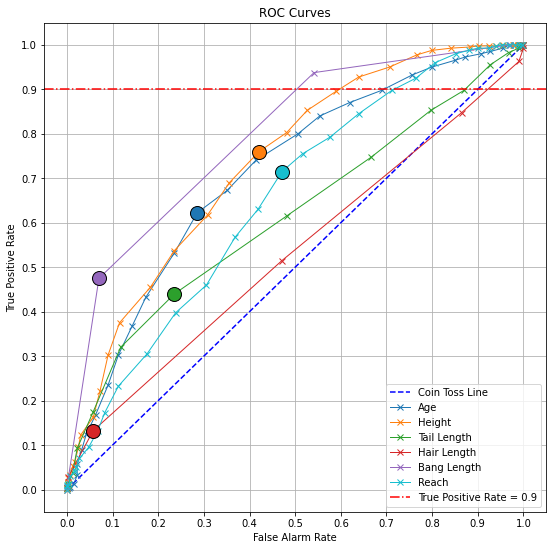

In [198]:
figure, ax = plt.subplots(figsize=(9,9))
plt.title(f'ROC Curves') 

plt.xlabel('False Alarm Rate')
plt.ylabel('True Positive Rate')
plt.xticks( [ tick*0.1 for tick in range(0,11) ] )
plt.yticks( [ tick*0.1 for tick in range(0,11) ] )

plt.grid()
plt.plot( [0,1], [0,1], color='blue', linestyle='--', label='Coin Toss Line' )

colors = ['tab:blue','tab:orange', 'tab:green', 'tab:red', 'tab:purple','tab:cyan']

for index, attribute_name in enumerate(attributes.keys()):
    attribute_data = attributes[attribute_name]
    results = get_roc_data(target, attribute_name, attribute_data, labels)
    plt.plot( results[0], results[1], color = colors[index], marker = 'x', linewidth=1, label = attribute_name ) 

for index, attribute_name in enumerate(attributes.keys()):
    attribute_data = attributes[attribute_name]
    results = get_roc_data(target, attribute_name, attribute_data, labels)
    plt.plot( results[2], results[3], color='k', marker = 'o', markerfacecolor = colors[index], markersize=14 )

plt.axhline( 0.90, color = 'red', label = 'True Positive Rate = 0.9', linestyle = '-.' )

plt.legend()
plt.show()